In [65]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from lightgbm import LGBMRegressor
from pathlib import Path

pd.set_option('display.max_columns', None)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [66]:
DATA_PATH = Path('')

# Load files
train = pd.read_csv(DATA_PATH / 'Train.csv')
test = pd.read_csv(DATA_PATH / 'Test.csv')
sample_submission = pd.read_csv(DATA_PATH / 'SampleSubmission.csv')

In [67]:
train.head()

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
0,id_vjcx08sz91,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-10-25,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052301,828817.9375,-100.805145,21.720518,-123.523796,33.745914,0.122055,2.301404,0.285803,230.693756,0.906039,-100.805145,21.720518,-123.523796,33.745914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.015000
1,id_bkg215syli,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-02,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,0.045475,3771.027210,3399.756845,828569.623806,69.245351,59.159695,-143.370575,26.566997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000214,1.462390,0.000240,0.359150,26.525513,-143.480164,59.220097,70.875954,-0.315206,828578.6250,70.875954,59.220097,-143.480164,26.525513,0.116975,3.049902,0.362203,228.260193,0.364713,70.875954,59.220097,-143.480164,26.525513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.267200
2,id_oui2pot3qd,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-03,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.097816,828878.6875,-96.411942,61.045010,-121.307121,41.898113,0.117559,3.248703,0.384168,224.102463,0.754163,-96.411942,61.045010,-121.307121,41.898113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7

In [68]:
# Preview the first five rows of the sample submission file
sample_submission.head()

,id,pm2_5
0,id_ihxgrbq8bw,0
1,id_dg6s4fhiwe,0
2,id_f7hwwtmuzp,0
3,id_ioese5awdg,0
4,id_hdw320zpls,0


In [69]:
# split train into a train and test set 
train, test = train_test_split(train, test_size=0.2, random_state=42)

In [70]:
#for each column, check how many non-empty rows are in the dataframe
# train.info()

#drop the columns less than 75% full
train = train.dropna(thresh=0.25*len(train), axis=1)
test = test[train.columns]

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6456 entries, 7709 to 7270
Data columns (total 73 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   id                                                        6456 non-null   object 
 1   site_id                                                   6456 non-null   object 
 2   site_latitude                                             6456 non-null   float64
 3   site_longitude                                            6456 non-null   float64
 4   city                                                      6456 non-null   object 
 5   country                                                   6456 non-null   object 
 6   date                                                      6456 non-null   object 
 7   hour                                                      6456 non-null   int64  
 8   sulphurdioxide_so2_c

In [71]:


# combine city and country into one column
train['Location'] = train['country'] + ', ' + train['city']
test['Location'] = test['country'] + ', ' + test['city']
train.drop(['country', 'city'], axis=1, inplace=True)
test.drop(['country', 'city'], axis=1, inplace=True)

train.describe()

,site_latitude,site_longitude,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
count,6456.000000,6456.000000,6456.000000,2535.000000,2535.000000,2535.000000,2535.000000,2535.000000,2535.000000,2535.000000,2535.000000,2535.000000,6456.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,6452.000000,6452.000000,6452.000000,6452.000000,6452.000000,6452.000000,6374.000000,6374.000000,6374.000000,6374.000000,6374.000000,6374.000000,6374.000000,6374.000000,6374.000000,3981.000000,3981.000000,3981.000000,3981.000000,3981.000000,3981.000000,3981.000000,3981.000000,3981.000000,3981.000000,3981.000000,6456.000000
mean,0.611788,30.343979,10.874690,0.000026,0.688080,0.000014,0.126743,2.080935,38.417842,-92.787493,27.680127,0.000004,6.159077,0.034820,2191.887693,2040.661575,829572.433181,-6.745207,38.493901,-91.637623,28.498738,0.000074,0.000041,0.000033,0.000130,8839.601210,-0.380403,0.081159,829587.275378,-12.642071,37.134815,-93.669248,28.773575,0.000174,1.046655,0.000109,0.191979,28.021846,-92.017537,39.988519,-2.938735,-0.448394,829600.321694,-12.767938,41.344141,-88.883719,28.410662,0.117710,2.648199,0.316087,228.271748,0.515899,-13.419094,41.248820,-88.669701,28.552058,0.582198,52194.676225,6027.860581,58857.262552,5044.541285,16.720116,0.255197,-19.597750,45.804133,-85.079130,28.722077,24.439187
std,2.135051,9.288564,0.808708,0.000349,0.139402,0.000220,0.093840,85.490447,18.915208,43.183977,6.781604,0.000092,3.422476,0.011071,896.191942,1348.344496,338.077541,82.928988,18.277359,41.684867,6.623538,0.000034,0.000034,0.000002,0.000041,993.638661,0.763657,

In [72]:
# draw a correlation matrix for the columns that include: "uvaerosolindex", "ozone", 

In [73]:
# summarise categorical variables
train.describe(include=['O'])

,id,site_id,date,Location
count,6456,6456,6456,6456
unique,6456,69,323,4
top,id_n9zf7av5aw,616fe4ce9657420029658b3e,2024-01-25,"Uganda, Kampala"
freq,1,229,48,4472


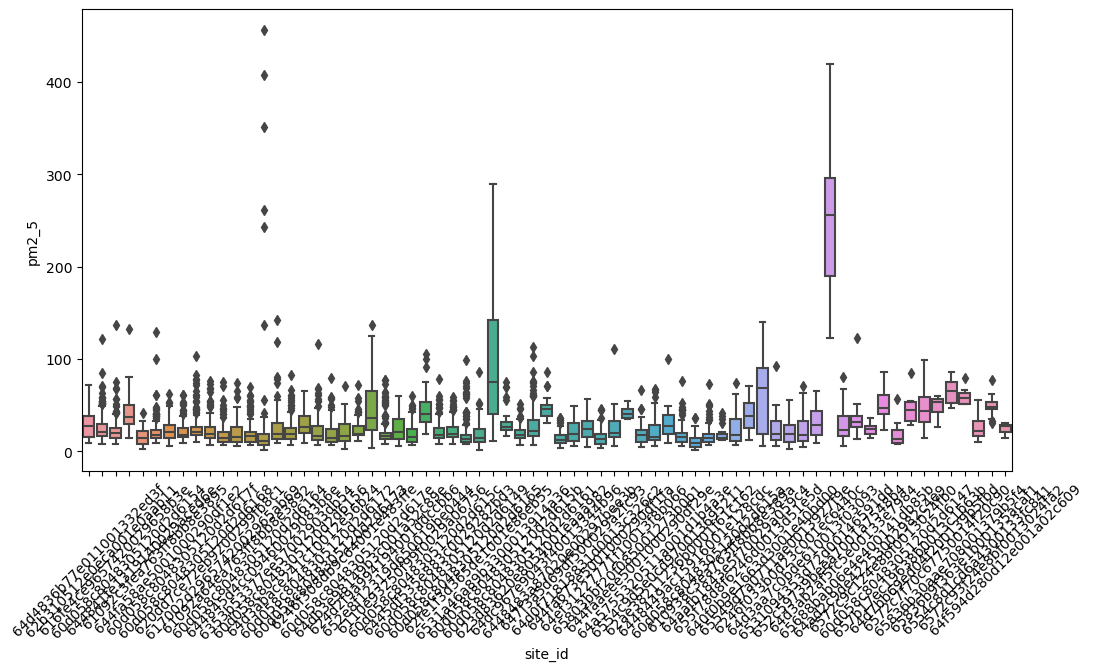

In [74]:
# show pm2_5 distributions based on the site_id
plt.figure(figsize=(12, 6))
sns.boxplot(x='site_id', y='pm2_5', data=train)
plt.xticks(rotation=45)
plt.show()

In [75]:
#drop all rows with missing values
train = train.dropna()
test = test.dropna()

#print the number of data values
train.shape

(860, 72)

In [76]:
# summarise categorical variables
train.describe(include=['O'])

# summarise the distributions of pm2_5 based on the Location variable
train.groupby('Location')['pm2_5'].describe()

,count,mean,std,min,25%,50%,75%,max
Location,,,,,,,,
"Burundi, Bujumbura",11.0,28.079065,8.689817,15.45475,19.328711,32.742105,35.073917,38.00125
"Kenya, Nairobi",151.0,16.886591,9.226804,1.49600,9.572489,15.431667,21.502520,45.23400
"Nigeria, Lagos",118.0,54.507808,61.861195,7.92550,18.481272,34.593100,61.139934,326.04475
"Uganda, Kampala",580.0,21.513417,12.758449,5.50560,14.094100,17.417250,24.100950,80.52470


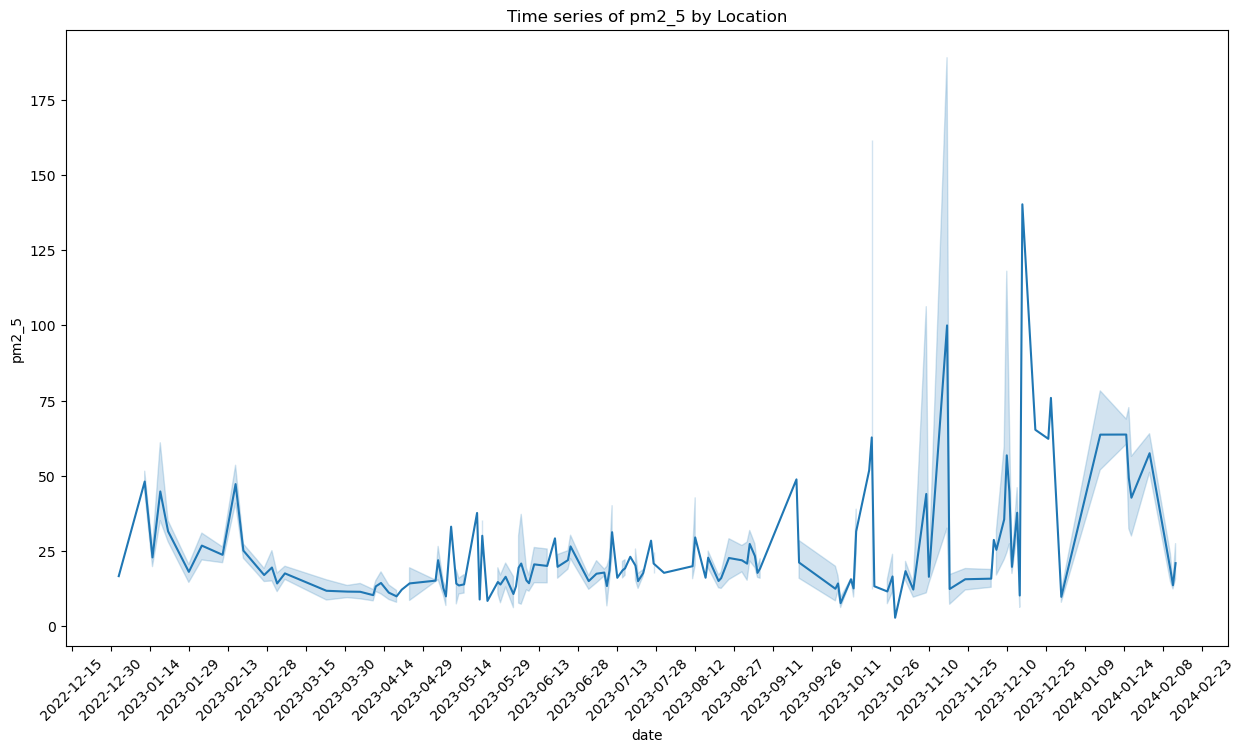

In [77]:
import matplotlib.dates as mdates

# Assume `df` is your DataFrame
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

plt.figure(figsize=(15, 8))

# Create the lineplot
sns.lineplot(x='date', y='pm2_5', data=train)

# Set the x-ticks to be every nth date, where n is the number of days between each tick
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))  # Set interval to your liking
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('Time series of pm2_5 by Location')
plt.xticks(rotation=45)  # Rotate x-tick labels for better visibility
plt.show()

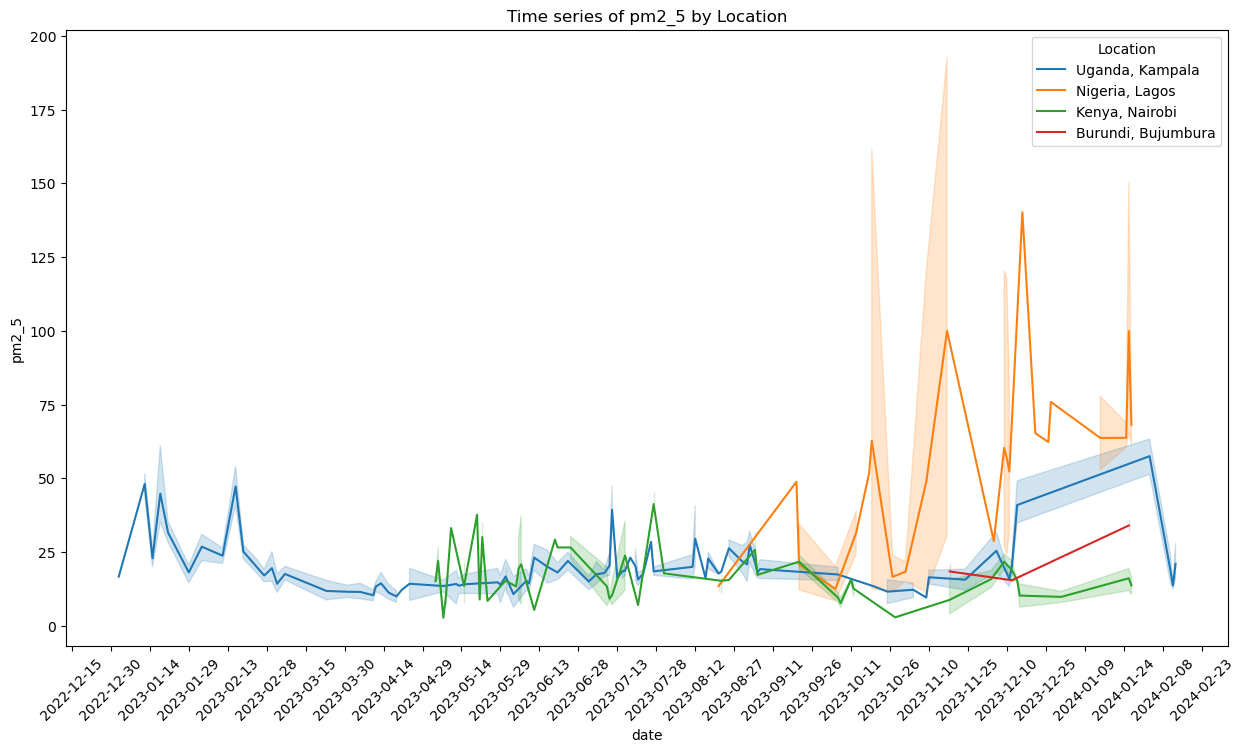

In [78]:
import matplotlib.dates as mdates

# Assume `df` is your DataFrame
train['date'] = pd.to_datetime(train['date'])

plt.figure(figsize=(15, 8))

# Create the lineplot
sns.lineplot(x='date', y='pm2_5', data=train, hue='Location')

# Set the x-ticks to be every nth date, where n is the number of days between each tick
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))  # Set interval to your liking
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('Time series of pm2_5 by Location')
plt.xticks(rotation=45)  # Rotate x-tick labels for better visibility
plt.show()

In [79]:
# list the columns of train
print(train.columns)

Index(['id', 'site_id', 'site_latitude', 'site_longitude', 'date', 'hour',
       'sulphurdioxide_so2_column_number_density',
       'sulphurdioxide_so2_column_number_density_amf',
       'sulphurdioxide_so2_slant_column_number_density',
       'sulphurdioxide_cloud_fraction', 'sulphurdioxide_sensor_azimuth_angle',
       'sulphurdioxide_sensor_zenith_angle',
       'sulphurdioxide_solar_azimuth_angle',
       'sulphurdioxide_solar_zenith_angle',
       'sulphurdioxide_so2_column_number_density_15km', 'month',
       'carbonmonoxide_co_column_number_density',
       'carbonmonoxide_h2o_column_number_density',
       'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude',
       'carbonmonoxide_sensor_azimuth_angle',
       'carbonmonoxide_sensor_zenith_angle',
       'carbonmonoxide_solar_azimuth_angle',
       'carbonmonoxide_solar_zenith_angle',
       'nitrogendioxide_no2_column_number_density',
       'nitrogendioxide_tropospheric_no2_column_number_density',
       'nitrog

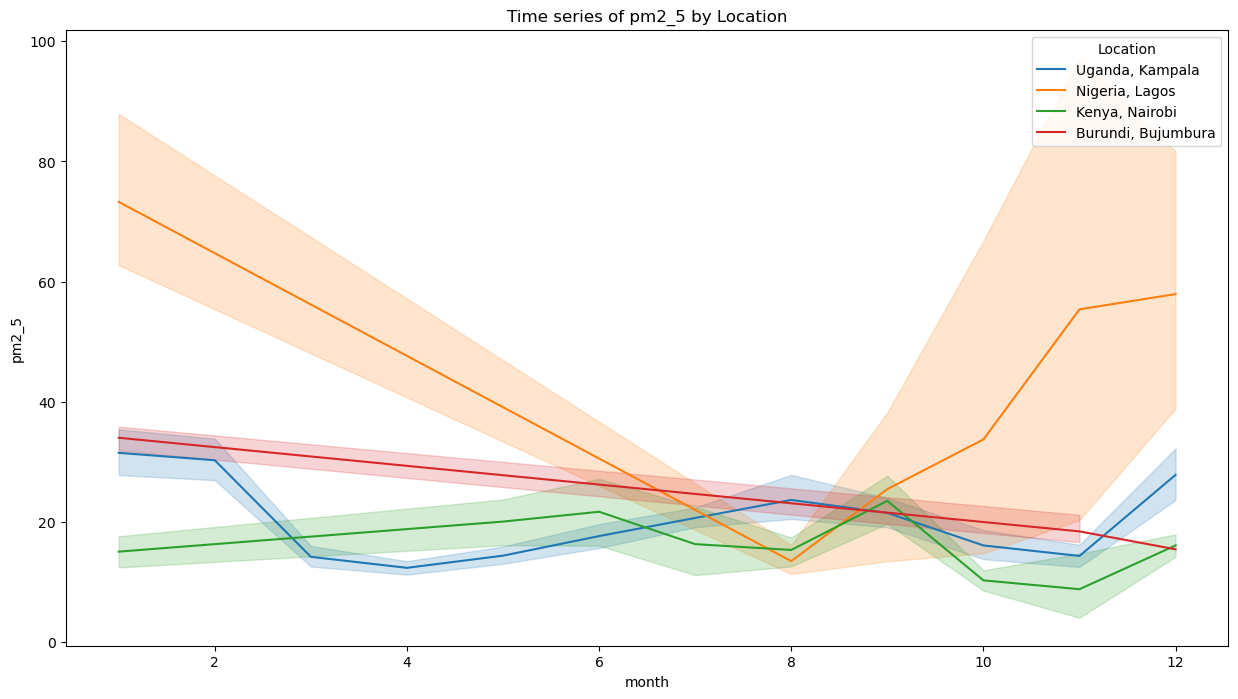

In [80]:
# lets check the correlation of date and pm2_5 using a pretty time series graph, for each location
plt.figure(figsize=(15, 8))
 
sns.lineplot(x='month', y='pm2_5', data=train, hue='Location')
plt.title('Time series of pm2_5 by Location')
plt.show()

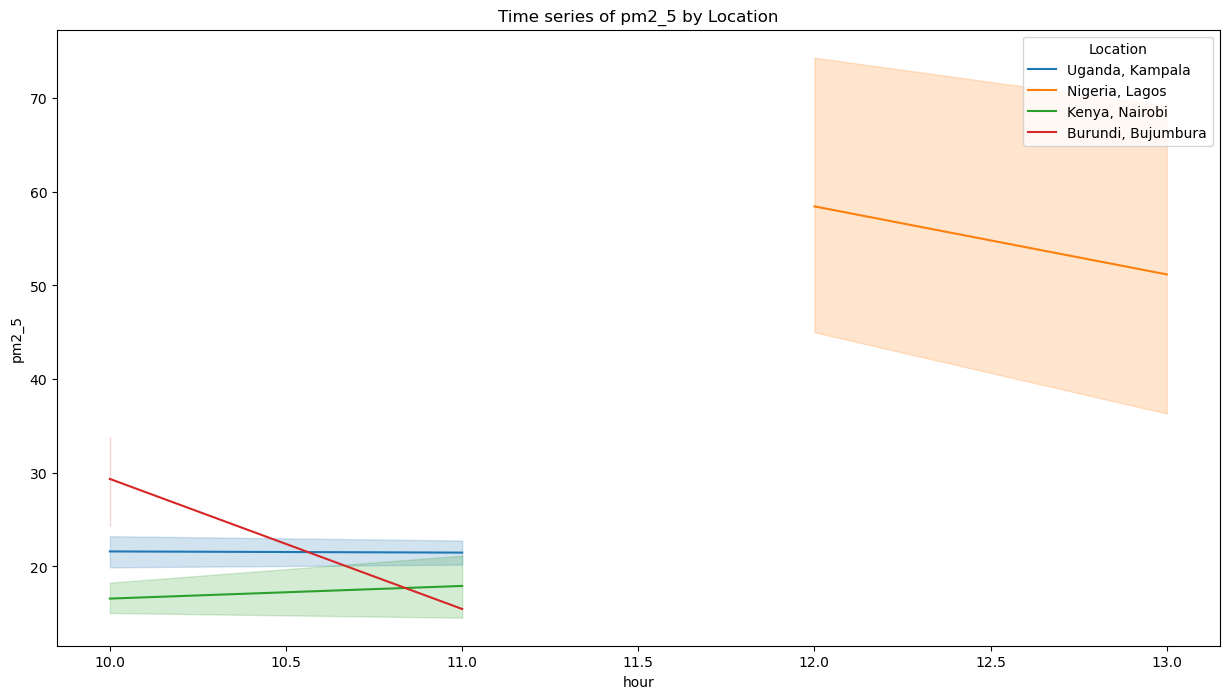

In [81]:
# lets check the correlation of date and pm2_5 using a pretty time series graph, for each location
plt.figure(figsize=(15, 8))
 
sns.lineplot(x='hour', y='pm2_5', data=train, hue='Location')
plt.title('Time series of pm2_5 by Location')
plt.show()

In [82]:
# list non-categorical columns
non_categorical = train.select_dtypes(include=[np.number]).columns
# remove hour, month, latitude and longitude from this list
non_categorical = non_categorical.drop(['hour', 'month', 'site_latitude', 'site_longitude', 'pm2_5'])
non_categorical

Index(['sulphurdioxide_so2_column_number_density',
       'sulphurdioxide_so2_column_number_density_amf',
       'sulphurdioxide_so2_slant_column_number_density',
       'sulphurdioxide_cloud_fraction', 'sulphurdioxide_sensor_azimuth_angle',
       'sulphurdioxide_sensor_zenith_angle',
       'sulphurdioxide_solar_azimuth_angle',
       'sulphurdioxide_solar_zenith_angle',
       'sulphurdioxide_so2_column_number_density_15km',
       'carbonmonoxide_co_column_number_density',
       'carbonmonoxide_h2o_column_number_density',
       'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude',
       'carbonmonoxide_sensor_azimuth_angle',
       'carbonmonoxide_sensor_zenith_angle',
       'carbonmonoxide_solar_azimuth_angle',
       'carbonmonoxide_solar_zenith_angle',
       'nitrogendioxide_no2_column_number_density',
       'nitrogendioxide_tropospheric_no2_column_number_density',
       'nitrogendioxide_stratospheric_no2_column_number_density',
       'nitrogendioxide_no2_slan

# Now we are training the regression model

In [83]:
# One-hot encode the 'site_id' column
train = pd.get_dummies(train, columns=['site_id'])
test = pd.get_dummies(test, columns=['site_id'])

In [84]:
# one hot encode the Location column
train = pd.get_dummies(train, columns=['Location'])
test = pd.get_dummies(test, columns=['Location'])

In [85]:
train.head()

,id,site_latitude,site_longitude,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5,site_id_60d058c8048305120d2d6147,site_id_60d058c8048305120d2d6149,site_id_60d058c8048305120d2d6154,site_id_60d058c8048305120d2d6156,site_id_60d058c8048305120d2d615a,site_id_60d058c8048305120d2d615b,site_id_60d058c8048305120d2d615c,site_id_60d058c8048305120d2d6161,site_id_60d058c8048305120d2d6164,site_id_60d058c8048305120d2d6165,site_id_60d058c8048305120d2d6168,site_id_60d058c8048305120d2d6172,site_id_60d058c8048305120d2d6173,site_id_60d058c8048305120d2d617e,site_id_60d058c8048305120d2d617f,site_id_61092a64ea763ff8bb8e3892,site_id_61092c3fea763ff8bb8e3895,site_id_610938c3ea763ff8bb8e389a,site_id_6110e93250f99f0029a06756,site_id_616fe4ce9657420029658b3e,site_id_617002d2965742002965ab69,site_id_620dd7ce72eb9200299fb8c1,site_id_623d83620e8054001eaaa982,site_id_6246f033b0d23c001ec6440c,site_id_6246f308db9c64001e483ffe,site_id_624d2f9a994194001ddccbb6,site_id_62ae38211236b0001f61c162,site_id_62b310512e0eca001e0aab11,site_id_62fe1f3d365de1001e86eb55,site_id_6353b53377ee57002903db54,site_id_640f0b9e1663d3001e40bd00,site_id_6445df535e883c0029282bd3,site_id_644841fe1319140029aced6e,site_id_6448449ac15916001e128cdc,site_id_644845d4cc09460029083b6e,site_id_6448483a87020e00297bee3b,site_id_644fa58ae5001000290df1e2,site_id_644fa673e5001000290df1fa,site_id_644faaeee5001000290df29e,site_id_647f3a5d69df500029a2fc93,site_id_64a5755320511a001d1b4a3e,site_id_64aafb1843e5f70029a059c4,site_id_64ad2c9de42253002982c4e9,site_id_64d0f71818831d0013c326c2,site_id_64d3aa7c0bde610013f03093,site_id_64d3ab2af5fc5e00133e7984,site_id_64d3abace241c10012e56b24,site_id_64d4836b77e011001332ed3f,site_id_64d7bb69ed04f200139b5fbd,site_id_64db3e98149b3c001a52c89e,site_id_64dc967e9043f40013344b96,site_id_64ef31227771f10013f8b066,site_id_652c59739beea7001a7548b4,site_id_652e8f12319d650019be

In [86]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd

# Drop the hour column
train = train.drop(columns=['hour', 'id'])
test = test.drop(columns=['hour', 'id'])

# One hot encode the
# Feature engineering
train['date'] = pd.to_datetime(train['date'])
train['day_of_week'] = train['date'].dt.dayofweek
train['day_of_month'] = train['date'].dt.day
train['year'] = train['date'].dt.year
test['date'] = pd.to_datetime(test['date'])
test['day_of_week'] = test['date'].dt.dayofweek
test['day_of_month'] = test['date'].dt.day
test['year'] = test['date'].dt.year

# Drop the original 'date' column
train = train.drop(columns=['date'])
test = test.drop(columns=['date'])
# Normalization
scaler = StandardScaler()
# scale the columns in the non-categorical columns list
train[non_categorical] = scaler.fit_transform(train[non_categorical])
test[non_categorical] = scaler.transform(test[non_categorical])


In [89]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Assume `train` and `test` are your DataFrames
X_train = train.drop(columns=['pm2_5'])
y_train = train['pm2_5']

# Define a function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create a scorer to be used in cross_val_score
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Train the model with K-fold cross-validation
model = LinearRegression()
scores = cross_val_score(model, X_train, y_train, cv=5, scoring=rmse_scorer)  # cv=5 for 5-fold cross-validation

# cross_val_score negates the scores if greater_is_better=False, so negate the scores back
scores = -scores

print(f'Cross-validation RMSE: {scores}')
print(f'Average cross-validation RMSE: {scores.mean()}')

# Train the model on the entire training data and test on the test data
model.fit(X_train, y_train)

X_test = test.drop(columns=['pm2_5'])
y_test = test['pm2_5']

# Ensure the test set has the same columns as the training set
missing_cols = set(X_train.columns) - set(X_test.columns)
for c in missing_cols:
    X_test[c] = 0
X_test = X_test[X_train.columns]

test_preds = model.predict(X_test)
test_rmse = rmse(y_test, test_preds)

print(f'Test RMSE: {test_rmse}')

Cross-validation RMSE: [1.10334582e+01 8.87504559e+07 1.85302804e+01 1.29839522e+10
 1.18189086e+11]
Average cross-validation RMSE: 26252357676.968056
Test RMSE: 14.217261189436035


Train RMSE: 11.171289639552372
Test RMSE: 14.217261189436035
Train MAE: 6.553253293418038
Test MAE: 7.792253908026479


Text(0.5, 1.0, 'Actual vs Predicted values')

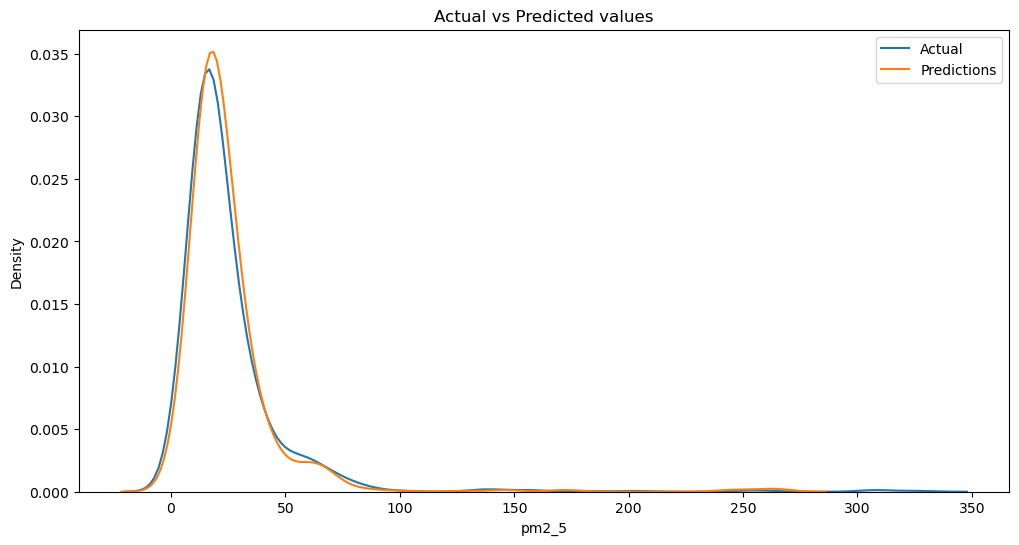

In [90]:
from sklearn.metrics import mean_absolute_error

# assess the model
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

train_mae = mean_absolute_error(y_train, train_preds)
test_mae = mean_absolute_error(y_test, test_preds)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

# make some graphs
plt.figure(figsize=(12, 6))
sns.kdeplot(y_train, label='Actual')
sns.kdeplot(train_preds, label='Predictions')
plt.legend()
plt.title('Actual vs Predicted values')

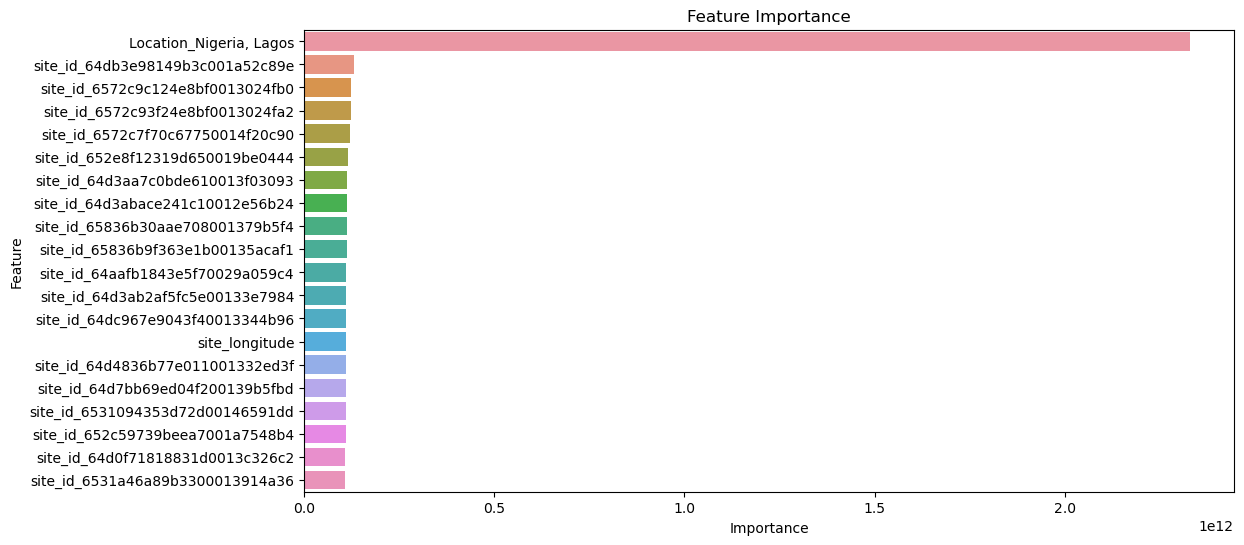

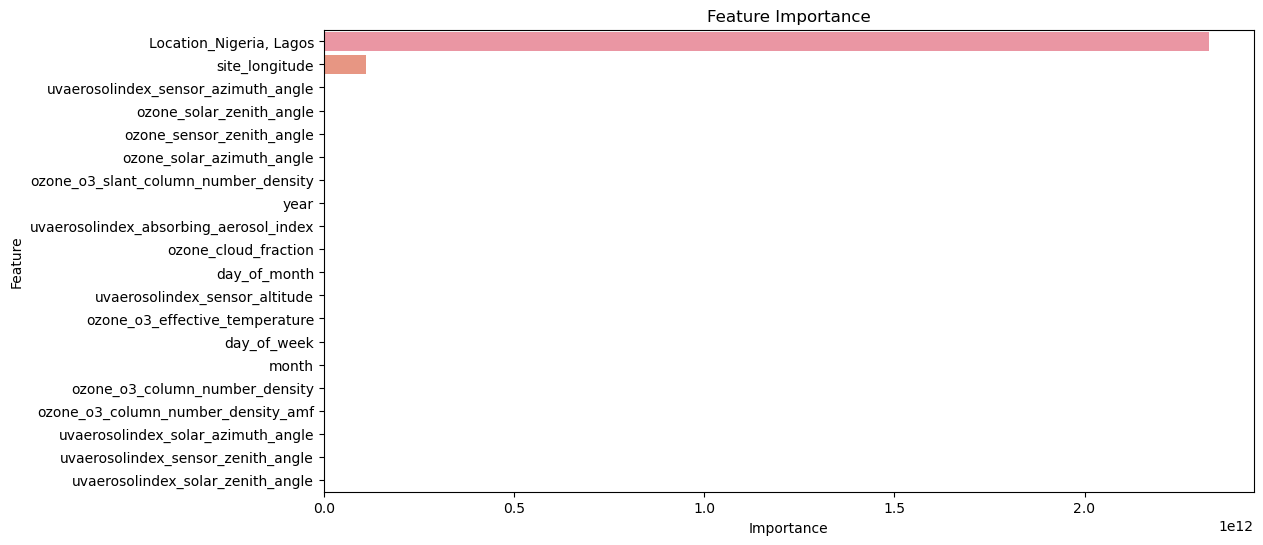

In [ ]:
# Assume `model` is your trained LinearRegression model and `X_train` is your feature DataFrame
feature_importance = model.coef_

# Create a DataFrame to store the feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the DataFrame in order of feature importance
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Feature Importance')
plt.show()

# plot the feature importance of the 20 most important features where the feature does not include "site_id"
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df[~feature_importance_df["Feature"].str.contains("site_id")].head(20))
plt.title('Feature Importance')
plt.show()

In [91]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
import numpy as np

# Define a function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create a scorer to be used in cross_val_score
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Assume `train` and `test` are your DataFrames
X_train = train.drop(columns=['pm2_5'])
y_train = train['pm2_5']

# Instantiate the model with adjusted parameters
rf = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42)

# Perform K-fold cross-validation
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring=rmse_scorer)  # cv=5 for 5-fold cross-validation

# cross_val_score negates the scores if greater_is_better=False, so negate the scores back
scores = -scores

print(f'Cross-validation RMSE: {scores}')
print(f'Average cross-validation RMSE: {scores.mean()}')

# Fit the model on the entire training data
rf.fit(X_train, y_train)

# Make predictions
train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

# Assess the model
train_rmse = rmse(y_train, train_preds)
test_rmse = rmse(y_test, test_preds)
train_mae = mean_absolute_error(y_train, train_preds)
test_mae = mean_absolute_error(y_test, test_preds)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

Cross-validation RMSE: [ 9.54027553 17.57122792 23.10867757 33.51441042 23.99289213]
Average cross-validation RMSE: 21.545496713141368
Train RMSE: 14.442389754891277
Test RMSE: 14.972635862207472
Train MAE: 5.641426075885049
Test MAE: 8.170442848950096


In [92]:
train.columns = train.columns.str.replace('[^a-zA-Z0-9_]', '_', regex=True)
test.columns = test.columns.str.replace('[^a-zA-Z0-9_]', '_', regex=True)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
import numpy as np
from lightgbm import LGBMRegressor

# Define a function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create a scorer to be used in cross_val_score
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Assume `train` and `test` are your DataFrames
X_train = train.drop(columns=['pm2_5'])
y_train = train['pm2_5']

# Instantiate the model
model = LGBMRegressor()

# Perform K-fold cross-validation
scores = cross_val_score(model, X_train, y_train, cv=5, scoring=rmse_scorer)  # cv=5 for 5-fold cross-validation

# cross_val_score negates the scores if greater_is_better=False, so negate the scores back
scores = -scores

print(f'Cross-validation RMSE: {scores}')
print(f'Average cross-validation RMSE: {scores.mean()}')

# Fit the model on the entire training data
model.fit(X_train, y_train)

# Make predictions
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Assess the model
train_rmse = rmse(y_train, train_preds)
test_rmse = rmse(y_test, test_preds)
train_mae = mean_absolute_error(y_train, train_preds)
test_mae = mean_absolute_error(y_test, test_preds)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14658
[LightGBM] [Info] Number of data points in the train set: 688, number of used features: 81
[LightGBM] [Info] Start training from score 25.922915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

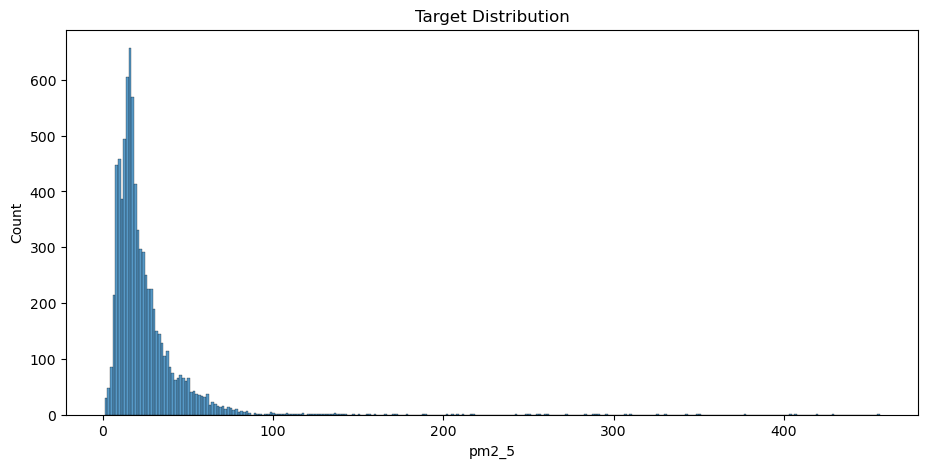

In [ ]:

# target distribution
plt.figure(figsize = (11, 5))
sns.histplot(train.pm2_5)
plt.title('Target Distribution')
plt.show()

- From the target distribution histogram we can see that the distribution is skewed to the right.
- Some processing of the target is recommended

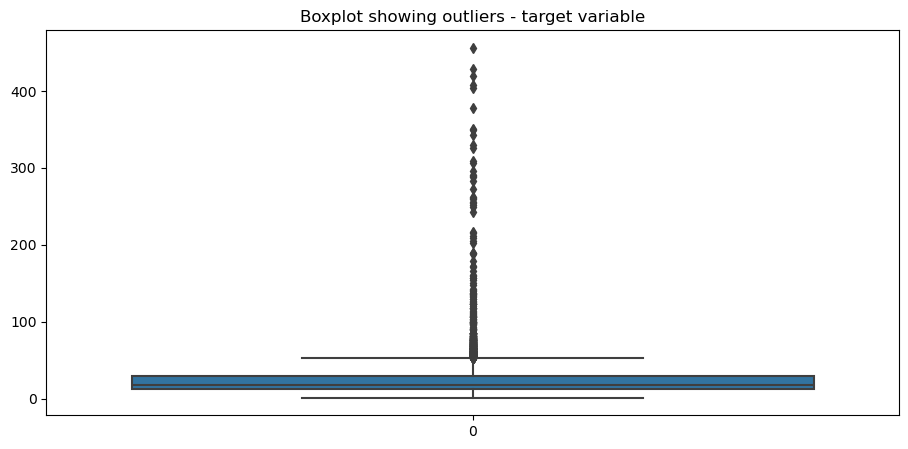

In [ ]:
# Check for outliers in the target variable
plt.figure(figsize = (11, 5))
sns.boxplot(train.pm2_5)
plt.title('Boxplot showing outliers - target variable')
plt.show()

- The target variable has some outliers that are beyond the 180 mark.
- Outliers can be handled via
  - Dropping them
  - Cap outliers - set a maximum
  - Assign a new value to the outliers
  - Transform the target variable


In [ ]:
# print a summary of each variable
train.describe()

,site_latitude,site_longitude,month,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,pm2_5,day_of_week,day_of_month,year
count,7959.000000,7959.000000,7959.00000,7.959000e+03,7.959000e+03,7.959000e+03,7.959000e+03,7.959000e+03,7.959000e+03,7.959000e+03,7.959000e+03,7.959000e+03,7.959000e+03,7.959000e+03,7.959000e+03,7.959000e+03,7959.000000,7.959000e+03,7959.000000,7959.000000,7959.000000,7959.000000
mean,0.640621,30.211743,6.14047,2.053334e-17,-1.750083e-13,2.142609e-17,2.660406e-16,2.178319e-16,-3.749566e-16,-1.187363e-15,-2.562203e-16,9.927422e-16,6.542100e-15,2.343479e-16,-8.927538e-19,1.173971e-16,0.000000,1.606957e-16,24.678353,3.104661,14.966076,2023.097123
std,2.169024,9.453829,3.41682,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063,1.000063e+00,25.028233,1.887773,8.799838,0.296143
min,-3.459970,3.201510,1.00000,-2.992070e+00,-2.968331e+00,-1.091282e+00,-2.183442e+00,-1.850981e+00,-2.667132e+00,-3.188283e+00,-1.522185e+00,-1.896853e+00,-5.095018e+00,-1.412344e+00,-1.091282e+00,-2.183453e+00,-1.850989,-2.667149e+00,1.200000,0.000000,1.000000,2023.000000
25%,0.288630,32.568643,3.00000,-7.068632e-01,-6.910505e-01,-9.898563e-01,-7.628487e-01,-9.516413e-01,-6.702530e-01,-4.282208e-01,-8.879088e-01,-8.563106e-01,-6.114287e-01,-9.291562e-01,-9.898563e-01,-7.628483e-01,-0.951646,-6.702600e-01,13.225700,2.000000,7.000000,2023.000000
50%,0.332610,32.600480,6.00000,-2.286169e-02,9.779324e-02,-9.544157e-01,2.340956e-01,1.306666e-01,2.447668e-02,2.202633e-01,-2.096003e-01,-1.809909e-01,3.693942e-02,-1.422697e-01,-9.544157e-01,2.341041e-01,0.130666,2.447328e-02,18.353800,3.000000,15.000000,2023.000000
75%,0.374653,32.647109,9.00000,5.915922e-01,6.844900e-01,1.003157e+00,8.559707e-01,9.296853e-01,7.422517e-01,6.729319e-01,7.749230e-01,7.406296e-01,6.668014e-01,1.131633e+00,1.003160e+00,8.559844e-01,0.929688,7.422520e-01,28.882450,5.000000,23.000000,2023.000000
max,6.595400,36.914272,12.00000,3.550638e+00,3.903211e+00,1.047565e+00,1.334496e+00,1.607002e+00,2.481205e+00,2.548217e+00,2.413955e+00,2.528334e+00,3.804942e+00,1.322258e+00,1.047565e+00,1.324737e+00,1.607007,2.481214e+00,456.193333,6.000000,31.000000,2024.000000


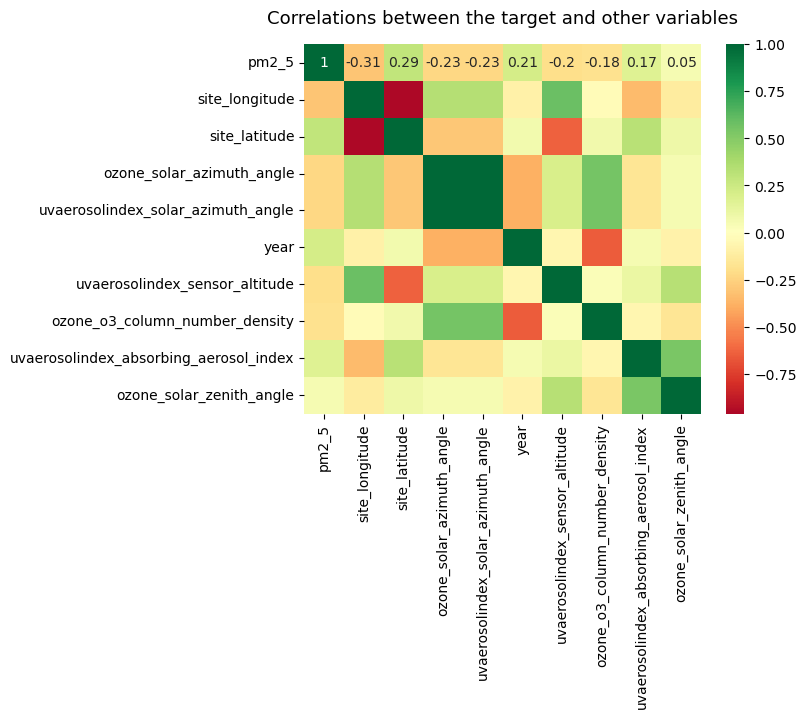

In [ ]:
# Select only numerical features
train_num_df = train.select_dtypes(include=['number'])

top10_corrs = abs(train_num_df.corr()['pm2_5']).sort_values(ascending = False).head(10)
corr = train_num_df[list(top10_corrs.index)].corr()
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlations between the target and other variables', pad = 15, fontdict={'size': 13})
plt.show()

In [ ]:
# Select X and y features for modelling
X = train_num_df.drop('pm2_5', axis = 1)
y = train.pm2_5

test_df = test[X.columns]
test_df.head()

KeyError: "['day_of_week', 'day_of_month', 'year'] not in index"

In [ ]:
train.head()

,id,site_id,site_latitude,site_longitude,date,hour,month,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,pm2_5,Location
0,id_vjcx08sz91,6531a46a89b3300013914a36,6.53257,3.39936,2023-10-25,13,10.0,0.052301,828817.9375,-100.805145,21.720518,-123.523796,33.745914,0.122055,2.301404,0.285803,230.693756,0.906039,-100.805145,21.720518,-123.523796,33.745914,12.015000,"Nigeria, Lagos"
1,id_bkg215syli,6531a46a89b3300013914a36,6.53257,3.39936,2023-11-02,12,11.0,-0.315206,828578.6250,70.875954,59.220097,-143.480164,26.525513,0.116975,3.049902,0.362203,228.260193,0.364713,70.875954,59.220097,-143.480164,26.525513,42.267200,"Nigeria, Lagos"
2,id_oui2pot3qd,6531a46a89b3300013914a36,6.53257,3.39936,2023-11-03,13,11.0,1.097816,828878.6875,-96.411942,61.045010,-121.307121,41.898113,0.117559,3.248703,0.384168,224.102463,0.754163,-96.411942,61.045010,-121.307121,41.898113,39.450741,"Nigeria, Lagos"
3,id_9aandqzy4n,6531a46a89b3300013914a36,6.53257,3.39936,2023-11-08,14,11.0,0.591543,828920.6875,-95.863083,65.508858,-122.218231,43.923038,0.118412,3.505708,0.416643,226.529633,1.000000,-95.863083,65.508858,-122.218231,43.923038,10.537600,"Nigeria, Lagos"
4,id_ali5x2m4iw,6531a46a89b3300013914a36,6.53257,3.39936,2023-11-09,13,11.0,0.069669,828919.0000,-97.811241,49.513344,-126.064468,40.167336,0.117899,2.796072,0.334256,226.368851,0.226150,-97.811241,49.513344,-126.064468,40.167336,19.431731,"Nigeria, Lagos"


In [ ]:
# Train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

model = LGBMRegressor()
model.fit(X_train, y_train)

# Local score
y_pred = model.predict(X_test)

score = mean_squared_error(y_test, y_pred, squared=False)
print('Local RMSE:', score)

[LightGBM] [Fatal] Do not support special JSON characters in feature name.


LightGBMError: Do not support special JSON characters in feature name.

In [ ]:
# Make predictions on the test set
preds = model.predict(test_df)

# Create submission file
sub = pd.DataFrame({'id': test['id'], 'pm2_5': preds})

# Preview sub file
sub.head()

,id,pm2_5
0,id_ihxgrbq8bw,15.201729
1,id_dg6s4fhiwe,20.077817
2,id_f7hwwtmuzp,16.099079
3,id_ioese5awdg,20.621268
4,id_hdw320zpls,18.518781


In [ ]:
# Create a csv file
sub.to_csv('submission.csv', index = False)